## Data Processing - ECS171 Project Group 8

**Description**: Converts true/false entries to 1/0 and normalizes numerical data

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [27]:
path_nontrend = 'datasets/11.09 nontrending.csv'
path_trend = 'datasets/11.09 trending.csv'
df_nontrend = pd.read_csv(path_nontrend)
df_trend = pd.read_csv(path_trend)
df_nontrend.head()

df_nontrend = df_nontrend.drop(['dimension'],axis=1)
df_trend = df_trend.drop(['dimension'],axis=1)
pd.set_option('display.max_columns', None)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
true_array = []
false_array = []
for i in df_trend.index:
    true_array.append(True)
for i in df_nontrend.index:
    false_array.append(False)

df_trend['trending?'] = true_array
df_nontrend['trending?'] = false_array

In [29]:
frames = [df_trend, df_nontrend]
# Link that teaches how to concatenate:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
df = pd.concat(frames, ignore_index=True, sort=False)
#df.reset_index(drop=True)
#df = df_trend
df = df.drop(['Unnamed: 0','is_trending'], axis=1)
#df.to_csv("~/CS/ECS-171-Group8/orig_DataProcessNotebook.csv")
#df.reset_index(drop=True)
df

,video_id,title,publishedAt,channelId,channelTitle,categoryId,duration,definition,time_retrieved,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,Channel_viewCount,Channel_subscriberCount,Channel_hiddenSubscriberCount,Channel_videoCount,Channel_title,Channel_description,Channel_publishedAt,Channel_country,view_count_update_11_09_18,likes_update_11_09_18,dislikes_update_11_09_18,comment_count_update_11_09_18,11_09_18_update_timestamp,view_count_update_11_10_19,likes_update_11_10_19,dislikes_update_11_10_19,comment_count_update_11_10_19,11_10_19_update_timestamp,view_count_update_11_11_18,likes_update_11_11_18,dislikes_update_11_11_18,comment_count_update_11_11_18,11_11_18_update_timestamp,view_count_update_11_12_18,likes_update_11_12_18,dislikes_update_11_12_18,comment_count_update_11_12_18,11_12_18_update_timestamp,view_count_update_11_13_19,likes_update_11_13_19,dislikes_update_11_13_19,comment_count_update_11_13_19,11_13_19_update_timestamp,view_count_update_11_14_18,likes_update_11_14_18,dislikes_update_11_14_18,comment_count_update_11_14_18,11_14_18_update_timestamp,view_count_update_11_15_18,likes_update_11_15_18,dislikes_update_11_15_18,comment_count_update_11_15_18,11_15_18_update_timestamp,trending?
0,vJYL4Osyipc,Biden Victory Cold Open - SNL,2020-11-08T06:34:11Z,UCqFzWxSCi39LnW1JKFR3efg,Saturday Night Live,24.0,PT8M7S,sd,2020-11-09T00:54:13Z,snl|saturday night live|season 46|snl 46|snl c...,9446895.0,206723.0,16043.0,19762.0,https://i.ytimg.com/vi/vJYL4Osyipc/default.jpg,False,False,Joe Biden (Jim Carrey) and Donald Trump (Alec ...,1.009461e+10,10900000.0,False,7408.0,"""Saturday Night Live""","""Welcome to the official Saturday Night Live c...","""2013-07-23T21:32:27Z""","""US""",11313866.0,235118.0,20469.0,23922.0,2020-11-09T18:14:52Z,13126479.0,255840.0,25370.0,27229.0,2020-11-10T19:14:33Z,13933338.0,264136.0,27323.0,28894.0,2020-11-11T18:48:06Z,14369831.0,269143.0,28436.0,30023.0,2020-11-12T18:35:36Z,14597842.0,272013.0,28860.0,30463.0,2020-11-13T19:06:00Z,14802727.0,274115.0,29218.0,30740.0,2020-11-14T18:20:10Z,15013816.0,275923.0,29538.0,30952.0,2020-11-15T18:11:45Z,True
1,moOxq_8l_34,How President Trump and the White House reacte...,2020-11-08T00:34:15Z,UCrp_UI8XtuYfpiqluWLD7Lw,CNBC Television,25.0,PT3M30S,hd,2020-11-09T00:54:13Z,news with shepard smith|shepard smith|news|eve...,4510545.0,39210.0,9544.0,24452.0,https://i.ytimg.com/vi/moOxq_8l_34/default.jpg,False,False,CNBC's Kayla Tausche joins The News with Shepa...,5.777748e+08,1050000.0,False,52344.0,"""CNBC Television""","""""","""2018-05-29T15:09:14Z""","""US""",5709174.0,48688.0,11741.0,28977.0,2020-11-09T18:14:52Z,6935738.0,55885.0,13804.0,31874.0,2020-11-10T19:14:33Z,7385430.0,58177.0,14326.0,33123.0,2020-11-11T18:48:06Z,7582572.0,59278.0,14621.0,33692.0,2020-11-12T18:35:36Z,7659043.0,59777.0,14738.0,34120.0,2020-11-13T19:06:00Z,7700861.0,60056.0,14837.0,34024.0,2020-11-14T18:20:10Z,7727616.0,60212.0,14893.0,34252.0,2020-11-15T18:11:45Z,True
2,452iQ8ttIcc,Watch Live: President-Elect Joe Biden Addresse...,2020-11-08T02:08:14Z,UCBi2mrWuNuyYy4gbM6fU18Q,ABC News,25.0,PT59M14S,hd,2020-11-09T00:54:13Z,2020 election|2020 presidential election|trump...,3560693.0,55120.0,7441.0,10486.0,https://i.ytimg.com/vi/452iQ8ttIcc/default.jpg,False,False,#Election2020 #Election #JoeBiden #PresidentEl...,8.619167e+09,10400000.0,False,56052.0,"""ABC News""","""Make ABC News your daily news outlet for brea...","""2006-08-07T23:12:21Z""","""US""",3691625.0,56424.0,6419.0,11795.0,2020-11-09T18:14:52Z,3768119.0,56957.0,7049.0,12492.0,2020-11-10T19:14:33Z,3783714.0,57038.0,7072.0,12387.0,2020-11-11T18:48:06Z,3792592.0,57097.0,7102.0,12447.0,2020-11-12T18:35:36Z,3806407.0,57159.0,7141.0,12524.0,2020-11-13T19:06:00Z,3814850.0,57233.0,7186.0,12479.0,2020-11-14T18:20:10Z,3827551.0,57265.0,7211.0,12545.0,2020-11-15T18:11:45Z,True
3,KW4pQFHKziI,I GOT PLASTIC SURGERY TO SEE HOW MY FRIENDS RE...,2020-11-07T21:30:34Z,UCPpATKqmMV-C

In [30]:
#normalize
from sklearn.preprocessing import StandardScaler
names_int = ['categoryId','view_count_update_11_09_18','likes_update_11_09_18','dislikes_update_11_09_18','comment_count_update_11_09_18']
df[names_int] = StandardScaler().fit_transform(df[names_int])
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,duration,definition,time_retrieved,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,Channel_viewCount,Channel_subscriberCount,Channel_hiddenSubscriberCount,Channel_videoCount,Channel_title,Channel_description,Channel_publishedAt,Channel_country,view_count_update_11_09_18,likes_update_11_09_18,dislikes_update_11_09_18,comment_count_update_11_09_18,11_09_18_update_timestamp,view_count_update_11_10_19,likes_update_11_10_19,dislikes_update_11_10_19,comment_count_update_11_10_19,11_10_19_update_timestamp,view_count_update_11_11_18,likes_update_11_11_18,dislikes_update_11_11_18,comment_count_update_11_11_18,11_11_18_update_timestamp,view_count_update_11_12_18,likes_update_11_12_18,dislikes_update_11_12_18,comment_count_update_11_12_18,11_12_18_update_timestamp,view_count_update_11_13_19,likes_update_11_13_19,dislikes_update_11_13_19,comment_count_update_11_13_19,11_13_19_update_timestamp,view_count_update_11_14_18,likes_update_11_14_18,dislikes_update_11_14_18,comment_count_update_11_14_18,11_14_18_update_timestamp,view_count_update_11_15_18,likes_update_11_15_18,dislikes_update_11_15_18,comment_count_update_11_15_18,11_15_18_update_timestamp,trending?
0,vJYL4Osyipc,Biden Victory Cold Open - SNL,2020-11-08T06:34:11Z,UCqFzWxSCi39LnW1JKFR3efg,Saturday Night Live,0.533722,PT8M7S,sd,2020-11-09T00:54:13Z,snl|saturday night live|season 46|snl 46|snl c...,9446895.0,206723.0,16043.0,19762.0,https://i.ytimg.com/vi/vJYL4Osyipc/default.jpg,False,False,Joe Biden (Jim Carrey) and Donald Trump (Alec ...,1.009461e+10,10900000.0,False,7408.0,"""Saturday Night Live""","""Welcome to the official Saturday Night Live c...","""2013-07-23T21:32:27Z""","""US""",6.079047,3.134435,9.215950,2.392006,2020-11-09T18:14:52Z,13126479.0,255840.0,25370.0,27229.0,2020-11-10T19:14:33Z,13933338.0,264136.0,27323.0,28894.0,2020-11-11T18:48:06Z,14369831.0,269143.0,28436.0,30023.0,2020-11-12T18:35:36Z,14597842.0,272013.0,28860.0,30463.0,2020-11-13T19:06:00Z,14802727.0,274115.0,29218.0,30740.0,2020-11-14T18:20:10Z,15013816.0,275923.0,29538.0,30952.0,2020-11-15T18:11:45Z,True
1,moOxq_8l_34,How President Trump and the White House reacte...,2020-11-08T00:34:15Z,UCrp_UI8XtuYfpiqluWLD7Lw,CNBC Television,0.670503,PT3M30S,hd,2020-11-09T00:54:13Z,news with shepard smith|shepard smith|news|eve...,4510545.0,39210.0,9544.0,24452.0,https://i.ytimg.com/vi/moOxq_8l_34/default.jpg,False,False,CNBC's Kayla Tausche joins The News with Shepa...,5.777748e+08,1050000.0,False,52344.0,"""CNBC Television""","""""","""2018-05-29T15:09:14Z""","""US""",2.950066,0.492687,5.191759,2.925863,2020-11-09T18:14:52Z,6935738.0,55885.0,13804.0,31874.0,2020-11-10T19:14:33Z,7385430.0,58177.0,14326.0,33123.0,2020-11-11T18:48:06Z,7582572.0,59278.0,14621.0,33692.0,2020-11-12T18:35:36Z,7659043.0,59777.0,14738.0,34120.0,2020-11-13T19:06:00Z,7700861.0,60056.0,14837.0,34024.0,2020-11-14T18:20:10Z,7727616.0,60212.0,14893.0,34252.0,2020-11-15T18:11:45Z,True
2,452iQ8ttIcc,Watch Live: President-Elect Joe Biden Addresse...,2020-11-08T02:08:14Z,UCBi2mrWuNuyYy4gbM6fU18Q,ABC News,0.670503,PT59M14S,hd,2020-11-09T00:54:13Z,2020 election|2020 presidential election|trump...,3560693.0,55120.0,7441.0,10486.0,https://i.ytimg.com/vi/452iQ8ttIcc/default.jpg,False,False,#Election2020 #Election #JoeBiden #PresidentEl...,8.619167e+09,10400000.0,False,56052.0,"""ABC News""","""Make ABC News your daily news outlet for brea...","""2006-08-07T23:12:21Z""","""US""",1.823711,0.602307,2.737961,1.111279,2020-11-09T18:14:52Z,3768119.0,56957.0,7049.0,12492.0,2020-11-10T19:14:33Z,3783714.0,57038.0,7072.0,12387.0,2020-11-11T18:48:06Z,3792592.0,57097.0,7102.0,12447.0,2020-11-12T18:35:36Z,3806407.0,57159.0,7141.0,12524.0,2020-11-13T19:06:00Z,3814850.0,57233.0,7186.0,12479.0,2020-11-14T18:20:10Z,3827551.0,57265.0,7211.0,12545.0,2020-11-15T18:11:45Z,True
3,KW4pQFHKziI,I GOT PLASTIC SURGERY TO SEE HOW MY FRIENDS RE...,2020-11-07T21:30:

In [31]:
# pd.set_option('display.max_rows', None)

print(df['duration'])

0            PT8M7S
1           PT3M30S
2          PT59M14S
3            PT8M1S
4           PT7M27S
            ...    
22729    "PT10M50S"
22730     "PT6M30S"
22731    "PT15M43S"
22732    "PT32M51S"
22733         "P0D"
Name: duration, Length: 22734, dtype: object


In [32]:
# df[df['duration'] != type(str)]

index = 0
lst_drop = []
for i in df['duration']:
    if type(i) != str:
        lst_drop.append(index)
    index += 1
df.drop(lst_drop, inplace = True)   

In [33]:
#-----------------------------
# installation: pip3 install isodate
import isodate
duration_seconds = []
# count = 0
# df.drop(df[df['duration']== np.nan].index,inplace=True)

for i in df['duration']:
#     count +=1
#     print(count)
    dur = isodate.parse_duration(i.replace('"','' ))
    duration_seconds.append(dur.total_seconds())
df['duration'] = duration_seconds

In [34]:
#calculating the engagement rate combined data 

#formula for calculating engagement rate
def engagementRate(likes, comment, subscriber):
    return (likes + comment)/subscriber

#drop any na values from the dataset
df = df.dropna()

#feed the data to the formul and store the result in engagement rate
df["engagement_rate"] = engagementRate(df["likes_update_11_15_18"],df["comment_count_update_11_15_18"], df["Channel_subscriberCount"])

#replace any inifite values with nan
df["engagement_rate"] = df["engagement_rate"].replace([np.inf, -np.inf], np.nan)

df.head(500)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,video_id,title,publishedAt,channelId,channelTitle,categoryId,duration,definition,time_retrieved,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,Channel_viewCount,Channel_subscriberCount,Channel_hiddenSubscriberCount,Channel_videoCount,Channel_title,Channel_description,Channel_publishedAt,Channel_country,view_count_update_11_09_18,likes_update_11_09_18,dislikes_update_11_09_18,comment_count_update_11_09_18,11_09_18_update_timestamp,view_count_update_11_10_19,likes_update_11_10_19,dislikes_update_11_10_19,comment_count_update_11_10_19,11_10_19_update_timestamp,view_count_update_11_11_18,likes_update_11_11_18,dislikes_update_11_11_18,comment_count_update_11_11_18,11_11_18_update_timestamp,view_count_update_11_12_18,likes_update_11_12_18,dislikes_update_11_12_18,comment_count_update_11_12_18,11_12_18_update_timestamp,view_count_update_11_13_19,likes_update_11_13_19,dislikes_update_11_13_19,comment_count_update_11_13_19,11_13_19_update_timestamp,view_count_update_11_14_18,likes_update_11_14_18,dislikes_update_11_14_18,comment_count_update_11_14_18,11_14_18_update_timestamp,view_count_update_11_15_18,likes_update_11_15_18,dislikes_update_11_15_18,comment_count_update_11_15_18,11_15_18_update_timestamp,trending?,engagement_rate
0,vJYL4Osyipc,Biden Victory Cold Open - SNL,2020-11-08T06:34:11Z,UCqFzWxSCi39LnW1JKFR3efg,Saturday Night Live,0.533722,487.0,sd,2020-11-09T00:54:13Z,snl|saturday night live|season 46|snl 46|snl c...,9446895.0,206723.0,16043.0,19762.0,https://i.ytimg.com/vi/vJYL4Osyipc/default.jpg,False,False,Joe Biden (Jim Carrey) and Donald Trump (Alec ...,1.009461e+10,10900000.0,False,7408.0,"""Saturday Night Live""","""Welcome to the official Saturday Night Live c...","""2013-07-23T21:32:27Z""","""US""",6.079047,3.134435,9.215950,2.392006,2020-11-09T18:14:52Z,13126479.0,255840.0,25370.0,27229.0,2020-11-10T19:14:33Z,13933338.0,264136.0,27323.0,28894.0,2020-11-11T18:48:06Z,14369831.0,269143.0,28436.0,30023.0,2020-11-12T18:35:36Z,14597842.0,272013.0,28860.0,30463.0,2020-11-13T19:06:00Z,14802727.0,274115.0,29218.0,30740.0,2020-11-14T18:20:10Z,15013816.0,275923.0,29538.0,30952.0,2020-11-15T18:11:45Z,True,0.028154
1,moOxq_8l_34,How President Trump and the White House reacte...,2020-11-08T00:34:15Z,UCrp_UI8XtuYfpiqluWLD7Lw,CNBC Television,0.670503,210.0,hd,2020-11-09T00:54:13Z,news with shepard smith|shepard smith|news|eve...,4510545.0,39210.0,9544.0,24452.0,https://i.ytimg.com/vi/moOxq_8l_34/default.jpg,False,False,CNBC's Kayla Tausche joins The News with Shepa...,5.777748e+08,1050000.0,False,52344.0,"""CNBC Television""","""""","""2018-05-29T15:09:14Z""","""US""",2.950066,0.492687,5.191759,2.925863,2020-11-09T18:14:52Z,6935738.0,55885.0,13804.0,31874.0,2020-11-10T19:14:33Z,7385430.0,58177.0,14326.0,33123.0,2020-11-11T18:48:06Z,7582572.0,59278.0,14621.0,33692.0,2020-11-12T18:35:36Z,7659043.0,59777.0,14738.0,34120.0,2020-11-13T19:06:00Z,7700861.0,60056.0,14837.0,34024.0,2020-11-14T18:20:10Z,7727616.0,60212.0,14893.0,34252.0,2020-11-15T18:11:45Z,True,0.089966
2,452iQ8ttIcc,Watch Live: President-Elect Joe Biden Addresse...,2020-11-08T02:08:14Z,UCBi2mrWuNuyYy4gbM6fU18Q,ABC News,0.670503,3554.0,hd,2020-11-09T00:54:13Z,2020 election|2020 presidential election|trump...,3560693.0,55120.0,7441.0,10486.0,https://i.ytimg.com/vi/452iQ8ttIcc/default.jpg,False,False,#Election2020 #Election #JoeBiden #PresidentEl...,8.619167e+09,10400000.0,False,56052.0,"""ABC News""","""Make ABC News your daily news outlet for brea...","""2006-08-07T23:12:21Z""","""US""",1.823711,0.602307,2.737961,1.111279,2020-11-09T18:14:52Z,3768119.0,56957.0,7049.0,12492.0,2020-11-10T19:14:33Z,3783714.0,57038.0,7072.0,12387.0,2020-11-11T18:48:06Z,3792592.0,57097.0,7102.0,12447.0,2020-11-12T18:35:36Z,3806407.0,57159.0,7141.0,12524.0,2020-11-13T19:06:00Z,3814850.0,57233.0,7186.0,12479.0,2020-11-14T18:20:10Z,3827551.0,57265.0,7211.0,12545.0,2020-11-15T18:11:45Z,True,0.006712
3,KW4pQFHKziI,I GOT PLASTIC SURGERY TO SEE 

In [35]:
df.columns

Index(['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle',
       'categoryId', 'duration', 'definition', 'time_retrieved', 'tags',
       'view_count', 'likes', 'dislikes', 'comment_count', 'thumbnail_link',
       'comments_disabled', 'ratings_disabled', 'description',
       'Channel_viewCount', 'Channel_subscriberCount',
       'Channel_hiddenSubscriberCount', 'Channel_videoCount', 'Channel_title',
       'Channel_description', 'Channel_publishedAt', 'Channel_country',
       'view_count_update_11_09_18', 'likes_update_11_09_18',
       'dislikes_update_11_09_18', 'comment_count_update_11_09_18',
       '11_09_18_update_timestamp', 'view_count_update_11_10_19',
       'likes_update_11_10_19', 'dislikes_update_11_10_19',
       'comment_count_update_11_10_19', '11_10_19_update_timestamp',
       'view_count_update_11_11_18', 'likes_update_11_11_18',
       'dislikes_update_11_11_18', 'comment_count_update_11_11_18',
       '11_11_18_update_timestamp', 'view_count_update

In [36]:
new_df = df.drop(['view_count_update_11_09_18', 'likes_update_11_09_18',
       'dislikes_update_11_09_18', 'comment_count_update_11_09_18',
       '11_09_18_update_timestamp', 'view_count_update_11_10_19',
       'likes_update_11_10_19', 'dislikes_update_11_10_19',
       'comment_count_update_11_10_19', '11_10_19_update_timestamp',
       'view_count_update_11_11_18', 'likes_update_11_11_18',
       'dislikes_update_11_11_18', 'comment_count_update_11_11_18',
       '11_11_18_update_timestamp', 'view_count_update_11_12_18',
       'likes_update_11_12_18', 'dislikes_update_11_12_18',
       'comment_count_update_11_12_18', '11_12_18_update_timestamp',
       'view_count_update_11_13_19', 'likes_update_11_13_19',
       'dislikes_update_11_13_19', 'comment_count_update_11_13_19',
       '11_13_19_update_timestamp', 'view_count_update_11_14_18',
       'likes_update_11_14_18', 'dislikes_update_11_14_18',
       'comment_count_update_11_14_18', '11_14_18_update_timestamp', '11_15_18_update_timestamp', 'view_count', 'likes', 'dislikes', 'comment_count'], axis = 1)
new_df

,video_id,title,publishedAt,channelId,channelTitle,categoryId,duration,definition,time_retrieved,tags,thumbnail_link,comments_disabled,ratings_disabled,description,Channel_viewCount,Channel_subscriberCount,Channel_hiddenSubscriberCount,Channel_videoCount,Channel_title,Channel_description,Channel_publishedAt,Channel_country,view_count_update_11_15_18,likes_update_11_15_18,dislikes_update_11_15_18,comment_count_update_11_15_18,trending?,engagement_rate
0,vJYL4Osyipc,Biden Victory Cold Open - SNL,2020-11-08T06:34:11Z,UCqFzWxSCi39LnW1JKFR3efg,Saturday Night Live,0.533722,487.0,sd,2020-11-09T00:54:13Z,snl|saturday night live|season 46|snl 46|snl c...,https://i.ytimg.com/vi/vJYL4Osyipc/default.jpg,False,False,Joe Biden (Jim Carrey) and Donald Trump (Alec ...,1.009461e+10,10900000.0,False,7408.0,"""Saturday Night Live""","""Welcome to the official Saturday Night Live c...","""2013-07-23T21:32:27Z""","""US""",15013816.0,275923.0,29538.0,30952.0,True,0.028154
1,moOxq_8l_34,How President Trump and the White House reacte...,2020-11-08T00:34:15Z,UCrp_UI8XtuYfpiqluWLD7Lw,CNBC Television,0.670503,210.0,hd,2020-11-09T00:54:13Z,news with shepard smith|shepard smith|news|eve...,https://i.ytimg.com/vi/moOxq_8l_34/default.jpg,False,False,CNBC's Kayla Tausche joins The News with Shepa...,5.777748e+08,1050000.0,False,52344.0,"""CNBC Television""","""""","""2018-05-29T15:09:14Z""","""US""",7727616.0,60212.0,14893.0,34252.0,True,0.089966
2,452iQ8ttIcc,Watch Live: President-Elect Joe Biden Addresse...,2020-11-08T02:08:14Z,UCBi2mrWuNuyYy4gbM6fU18Q,ABC News,0.670503,3554.0,hd,2020-11-09T00:54:13Z,2020 election|2020 presidential election|trump...,https://i.ytimg.com/vi/452iQ8ttIcc/default.jpg,False,False,#Election2020 #Election #JoeBiden #PresidentEl...,8.619167e+09,10400000.0,False,56052.0,"""ABC News""","""Make ABC News your daily news outlet for brea...","""2006-08-07T23:12:21Z""","""US""",3827551.0,57265.0,7211.0,12545.0,True,0.006712
3,KW4pQFHKziI,I GOT PLASTIC SURGERY TO SEE HOW MY FRIENDS RE...,2020-11-07T21:30:34Z,UCPpATKqmMV-CNRNWYaDUwiA,Alexa Rivera,0.807283,481.0,hd,2020-11-09T00:54:13Z,[none],https://i.ytimg.com/vi/KW4pQFHKziI/default.jpg,False,False,"This was definitely such a fun prank, their re...",7.233880e+08,5120000.0,False,125.0,"""Alexa Rivera""","""""","""2010-08-21T04:33:50Z""","""""",4885156.0,215156.0,8429.0,8766.0,True,0.043735
4,uyZ8GwksYqk,FC Barcelona 5 - 2 Real Betis - HIGHLIGHTS & G...,2020-11-07T17:31:34Z,UC0YatYmg5JRYzXJPxIdRd8g,beIN SPORTS USA,-0.423741,447.0,hd,2020-11-09T00:54:13Z,beIN SPORTS|beIN SPORTS USA|Futbol|Football|la...,https://i.ytimg.com/vi/uyZ8GwksYqk/default.jpg,False,False,Lionel Messi entró al segundo tiempo y resucit...,9.327622e+07,388000.0,False,6917.0,"""beIN SPORTS USA""","""The fastest growing network in the US offerin...","""2012-07-16T20:11:38Z""","""US""",1216462.0,9952.0,735.0,1599.0,True,0.029771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22729,vDkRDSRb-3o,13 Year Old Bunchie Young Had A CRAZY SUMMER! ...,2020-11-08T17:03:45Z,UCDtwmlSRVWsZsQSJjLS78VA,Overtime SZN,-0.423741,650.0,"""hd""",2020-11-09T00:58:05Z,"""bunchie young julian newman|bunchie vs julian...",https://i.ytimg.com/vi/vDkRDSRb-3o/default.jpg,False,False,Bunchie Episode 1 ▻▻ https://ovrt.me/3nkLxie M...,1.031787e+08,408000.0,False,599.0,"""Overtime SZN""","""Based in NYC, Overtime is a sports network fo...","""2017-08-24T21:14:21Z""","""""",38760.0,1175.0,22.0,109.0,False,0.003147
22730,WjFbwUpqTr0,What if &#39;Among Us&#39; Happened in Real Life?,2020-11-08T17:03:34Z,UCphTF9wHwhCt-BzIq-s4V-g,What If,1.080844,390.0,"""hd""",2020-11-09T00:58:05Z,"""what if|what happens if|scifi|science documen...",https://i.ytimg.com/vi/WjFbwUpqTr0/default.jpg,False,False,Get more insightful information about the game...,4.817540e+08,4440000.0,False,477.0,"""What If""","""An epic exploration of possibilities. What If...","""2018-07-18T15:31:35Z""","""CA""",180936.0,10689.0,4

In [37]:
new_df.columns
numeric_cols = ['duration', 'Channel_viewCount', 'Channel_subscriberCount', 'Channel_videoCount', 'view_count_update_11_15_18', 'likes_update_11_15_18', 'dislikes_update_11_15_18', 'comment_count_update_11_15_18',]
new_df[numeric_cols] = StandardScaler().fit_transform(new_df[numeric_cols])
new_df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,duration,definition,time_retrieved,tags,thumbnail_link,comments_disabled,ratings_disabled,description,Channel_viewCount,Channel_subscriberCount,Channel_hiddenSubscriberCount,Channel_videoCount,Channel_title,Channel_description,Channel_publishedAt,Channel_country,view_count_update_11_15_18,likes_update_11_15_18,dislikes_update_11_15_18,comment_count_update_11_15_18,trending?,engagement_rate
0,vJYL4Osyipc,Biden Victory Cold Open - SNL,2020-11-08T06:34:11Z,UCqFzWxSCi39LnW1JKFR3efg,Saturday Night Live,0.533722,-0.070807,sd,2020-11-09T00:54:13Z,snl|saturday night live|season 46|snl 46|snl c...,https://i.ytimg.com/vi/vJYL4Osyipc/default.jpg,False,False,Joe Biden (Jim Carrey) and Donald Trump (Alec ...,0.823012,0.505254,False,-0.188832,"""Saturday Night Live""","""Welcome to the official Saturday Night Live c...","""2013-07-23T21:32:27Z""","""US""",6.528804,3.390391,10.842960,2.886933,True,0.028154
1,moOxq_8l_34,How President Trump and the White House reacte...,2020-11-08T00:34:15Z,UCrp_UI8XtuYfpiqluWLD7Lw,CNBC Television,0.670503,-0.085808,hd,2020-11-09T00:54:13Z,news with shepard smith|shepard smith|news|eve...,https://i.ytimg.com/vi/moOxq_8l_34/default.jpg,False,False,CNBC's Kayla Tausche joins The News with Shepa...,-0.274776,-0.350755,False,1.160596,"""CNBC Television""","""""","""2018-05-29T15:09:14Z""","""US""",3.245857,0.580938,5.359441,3.209054,True,0.089966
2,452iQ8ttIcc,Watch Live: President-Elect Joe Biden Addresse...,2020-11-08T02:08:14Z,UCBi2mrWuNuyYy4gbM6fU18Q,ABC News,0.670503,0.095287,hd,2020-11-09T00:54:13Z,2020 election|2020 presidential election|trump...,https://i.ytimg.com/vi/452iQ8ttIcc/default.jpg,False,False,#Election2020 #Election #JoeBiden #PresidentEl...,0.652816,0.461802,False,1.271947,"""ABC News""","""Make ABC News your daily news outlet for brea...","""2006-08-07T23:12:21Z""","""US""",1.488603,0.542556,2.483074,1.090182,True,0.006712
3,KW4pQFHKziI,I GOT PLASTIC SURGERY TO SEE HOW MY FRIENDS RE...,2020-11-07T21:30:34Z,UCPpATKqmMV-CNRNWYaDUwiA,Alexa Rivera,0.807283,-0.071132,hd,2020-11-09T00:54:13Z,[none],https://i.ytimg.com/vi/KW4pQFHKziI/default.jpg,False,False,"This was definitely such a fun prank, their re...",-0.257979,0.002946,False,-0.407540,"""Alexa Rivera""","""""","""2010-08-21T04:33:50Z""","""""",1.965129,2.598953,2.939129,0.721304,True,0.043735
4,uyZ8GwksYqk,FC Barcelona 5 - 2 Real Betis - HIGHLIGHTS & G...,2020-11-07T17:31:34Z,UC0YatYmg5JRYzXJPxIdRd8g,beIN SPORTS USA,-0.423741,-0.072973,hd,2020-11-09T00:54:13Z,beIN SPORTS|beIN SPORTS USA|Futbol|Football|la...,https://i.ytimg.com/vi/uyZ8GwksYqk/default.jpg,False,False,Lionel Messi entró al segundo tiempo y resucit...,-0.330664,-0.408286,False,-0.203577,"""beIN SPORTS USA""","""The fastest growing network in the US offerin...","""2012-07-16T20:11:38Z""","""US""",0.312124,-0.073656,0.058270,0.021716,True,0.029771


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Channel_country', ylabel='count'>

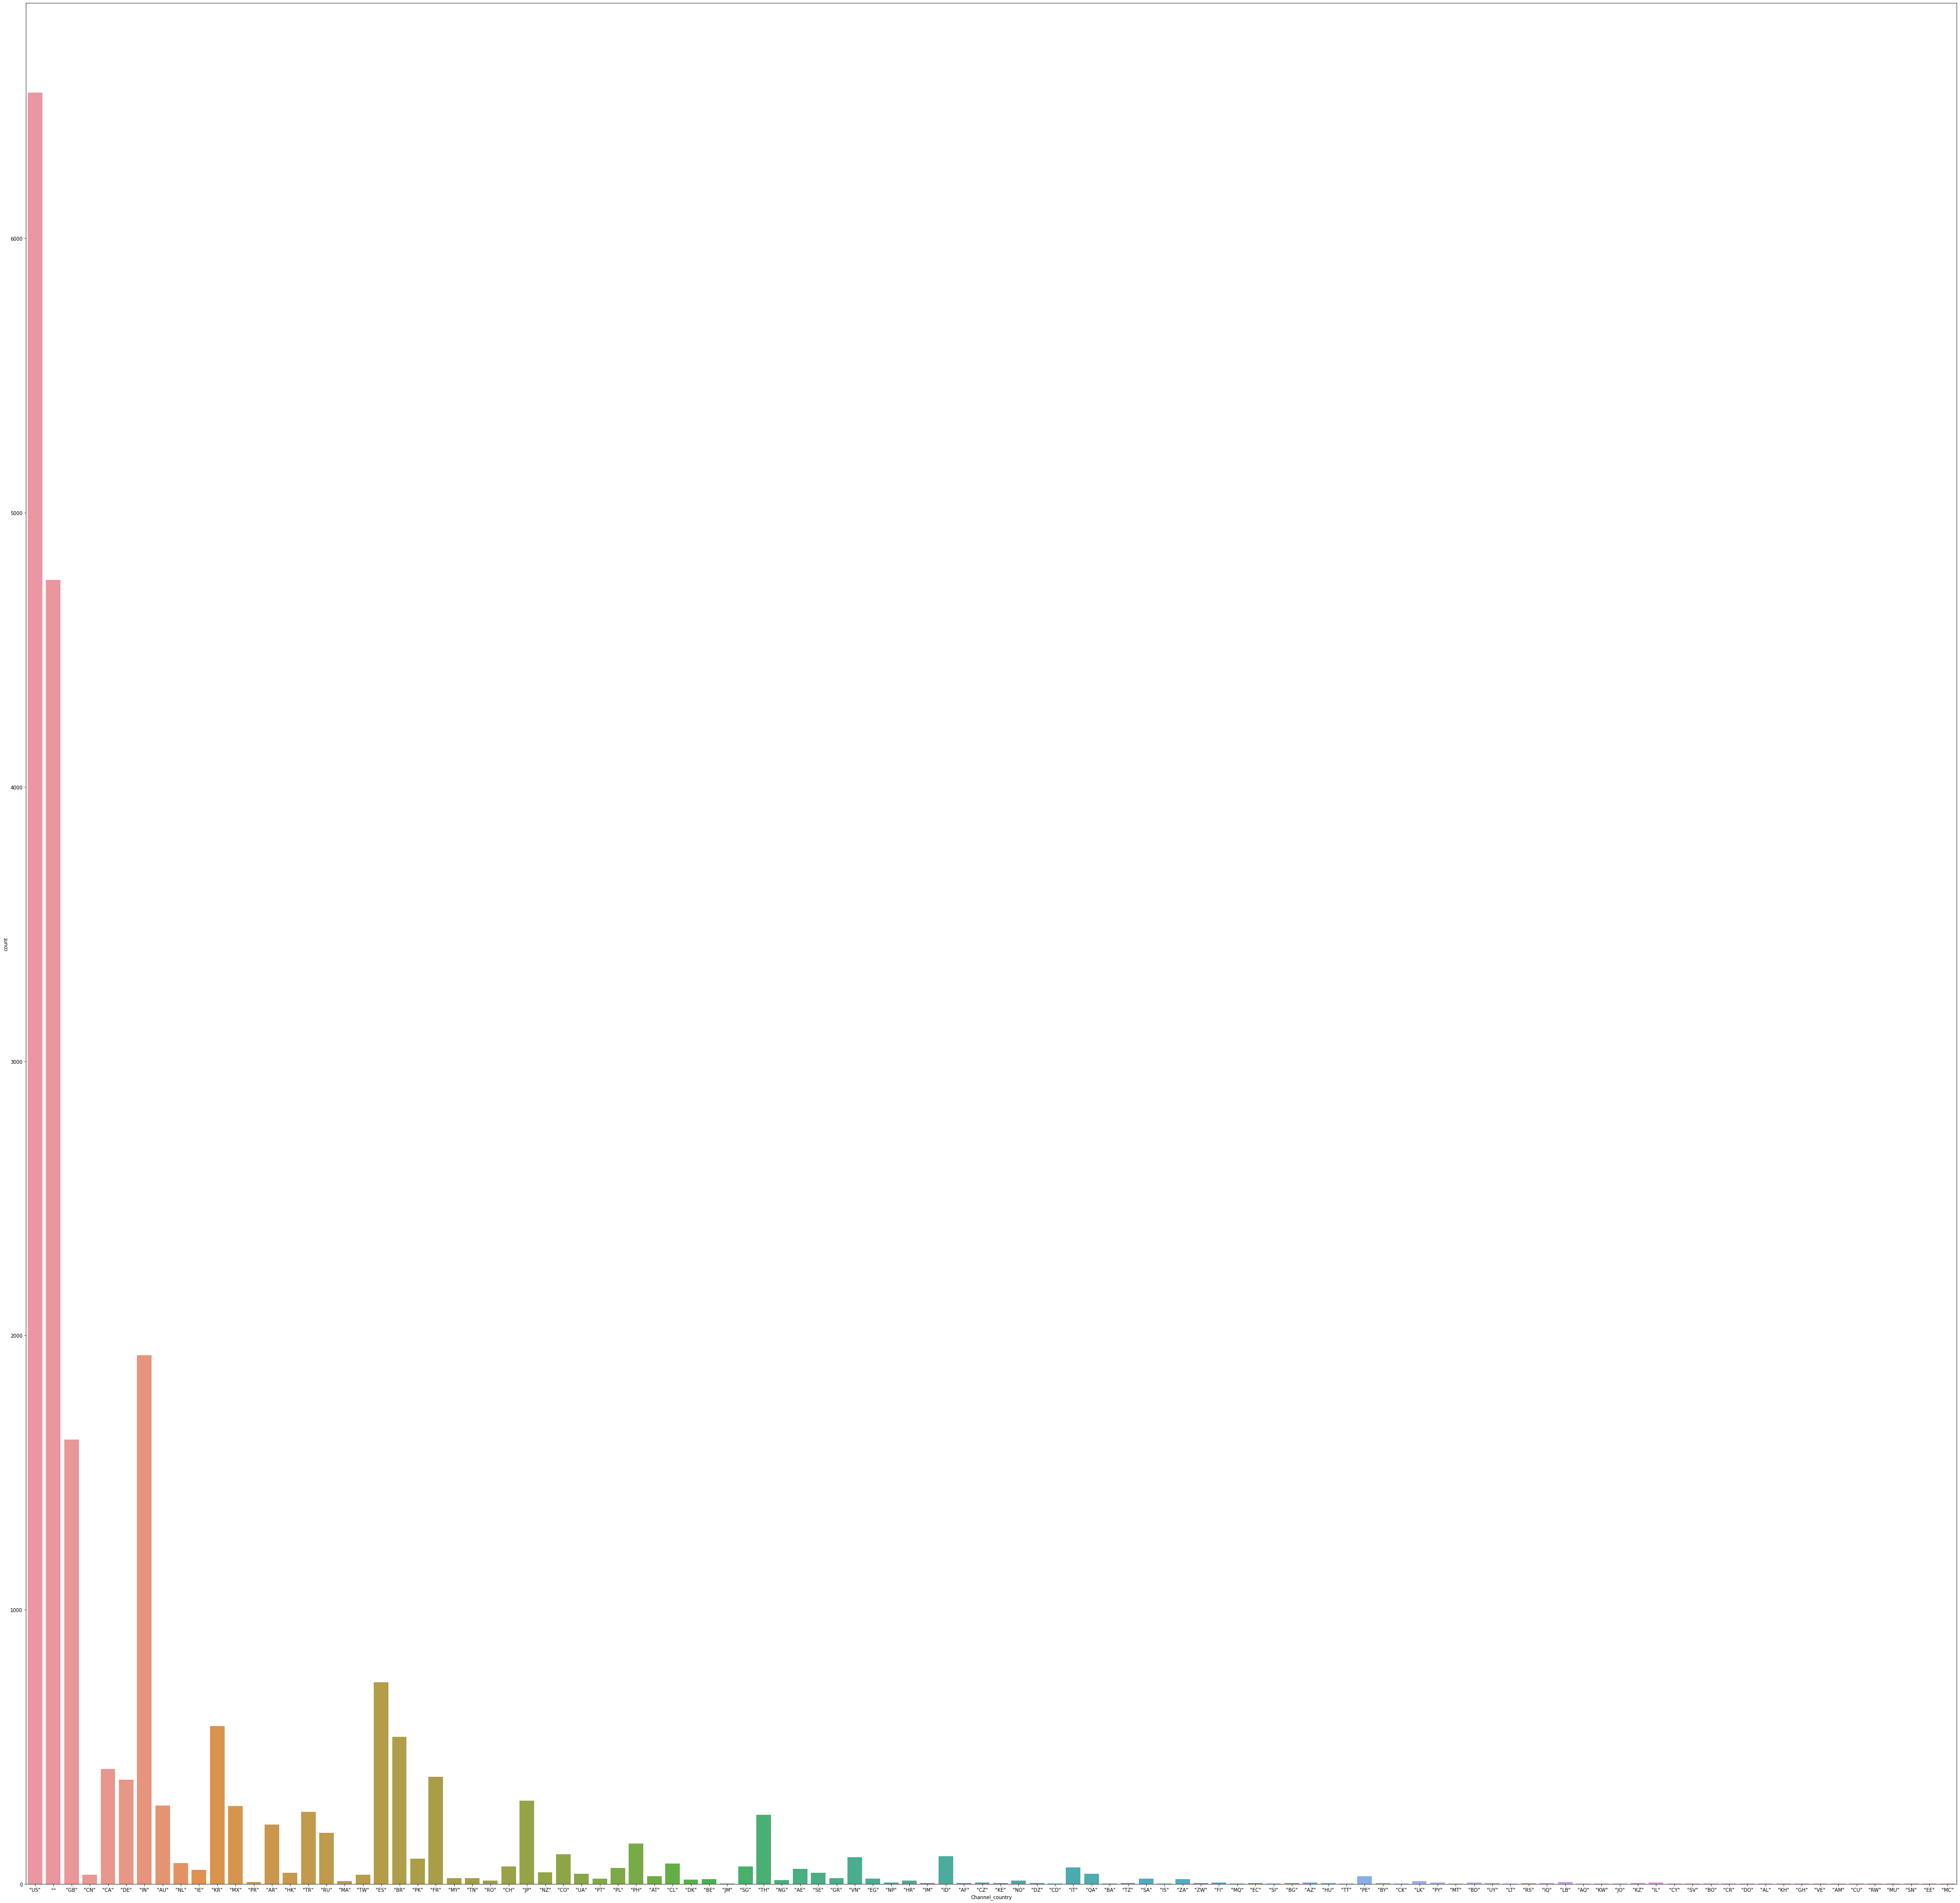

In [38]:
#plt.hist(new_df['Channel_country'])
plt.subplots(figsize=(71,71))
sns.countplot(new_df['Channel_country'])

In [39]:
#convert quotations '\"'
#function: remove_quote(column)
#use on nontrend (definition, Channel_country) and trend (Channel_country)
def remove_quote(col):
    lst = []
    for v in col:
        if type(v) == str:
            lst.append(v.replace('"',''))
        else:
            lst.append(v)
    return lst
new_df['definition'] = remove_quote(new_df['definition'])
new_df['Channel_country'] = remove_quote(new_df['Channel_country'])
# new_df['Channel_country'] = remove_quote(new_df['Channel_country'])



#sets 'tags' to number of tags
#function: count_tags(dataframe)
#use on nontrend and trend
def count_tags(df):
    lst=[]
    for entry in df['tags']:
        if entry == '[none]':
            lst.append(0)
        else:
            num_tags = entry.count('|')
            lst.append(num_tags)
    df['tags'] = lst
    return df
new_df = count_tags(new_df)
# df_trend = count_tags(df_trend)



#Channel_country: 0 for INTL, 1 for USA
#function: encode_country(dataframe)
#use on nontrend and trend
def encode_country(df):
    lst = []
    for entry in df['Channel_country']:
        if entry == 'US':
            lst.append(1)
        else:
            lst.append(0)
    df['Channel_country'] = lst
    return df
new_df = encode_country(new_df)
# df_trend = encode_country(df_trend)



#remove Channel_hiddenSubscriberCount == True rows
#function: clean_subcount(dataframe)
#use on nontrend
def clean_subcount(df):
    lst = []
    for i in df.index:
        if df['Channel_hiddenSubscriberCount'][i] == True:
            lst.append(i)
    return lst
new_df = new_df.drop(clean_subcount(new_df))

In [40]:
new_df

,video_id,title,publishedAt,channelId,channelTitle,categoryId,duration,definition,time_retrieved,tags,thumbnail_link,comments_disabled,ratings_disabled,description,Channel_viewCount,Channel_subscriberCount,Channel_hiddenSubscriberCount,Channel_videoCount,Channel_title,Channel_description,Channel_publishedAt,Channel_country,view_count_update_11_15_18,likes_update_11_15_18,dislikes_update_11_15_18,comment_count_update_11_15_18,trending?,engagement_rate
0,vJYL4Osyipc,Biden Victory Cold Open - SNL,2020-11-08T06:34:11Z,UCqFzWxSCi39LnW1JKFR3efg,Saturday Night Live,0.533722,-0.070807,sd,2020-11-09T00:54:13Z,36,https://i.ytimg.com/vi/vJYL4Osyipc/default.jpg,False,False,Joe Biden (Jim Carrey) and Donald Trump (Alec ...,0.823012,0.505254,False,-0.188832,"""Saturday Night Live""","""Welcome to the official Saturday Night Live c...","""2013-07-23T21:32:27Z""",1,6.528804,3.390391,10.842960,2.886933,True,0.028154
1,moOxq_8l_34,How President Trump and the White House reacte...,2020-11-08T00:34:15Z,UCrp_UI8XtuYfpiqluWLD7Lw,CNBC Television,0.670503,-0.085808,hd,2020-11-09T00:54:13Z,28,https://i.ytimg.com/vi/moOxq_8l_34/default.jpg,False,False,CNBC's Kayla Tausche joins The News with Shepa...,-0.274776,-0.350755,False,1.160596,"""CNBC Television""","""""","""2018-05-29T15:09:14Z""",1,3.245857,0.580938,5.359441,3.209054,True,0.089966
2,452iQ8ttIcc,Watch Live: President-Elect Joe Biden Addresse...,2020-11-08T02:08:14Z,UCBi2mrWuNuyYy4gbM6fU18Q,ABC News,0.670503,0.095287,hd,2020-11-09T00:54:13Z,13,https://i.ytimg.com/vi/452iQ8ttIcc/default.jpg,False,False,#Election2020 #Election #JoeBiden #PresidentEl...,0.652816,0.461802,False,1.271947,"""ABC News""","""Make ABC News your daily news outlet for brea...","""2006-08-07T23:12:21Z""",1,1.488603,0.542556,2.483074,1.090182,True,0.006712
3,KW4pQFHKziI,I GOT PLASTIC SURGERY TO SEE HOW MY FRIENDS RE...,2020-11-07T21:30:34Z,UCPpATKqmMV-CNRNWYaDUwiA,Alexa Rivera,0.807283,-0.071132,hd,2020-11-09T00:54:13Z,0,https://i.ytimg.com/vi/KW4pQFHKziI/default.jpg,False,False,"This was definitely such a fun prank, their re...",-0.257979,0.002946,False,-0.407540,"""Alexa Rivera""","""""","""2010-08-21T04:33:50Z""",0,1.965129,2.598953,2.939129,0.721304,True,0.043735
4,uyZ8GwksYqk,FC Barcelona 5 - 2 Real Betis - HIGHLIGHTS & G...,2020-11-07T17:31:34Z,UC0YatYmg5JRYzXJPxIdRd8g,beIN SPORTS USA,-0.423741,-0.072973,hd,2020-11-09T00:54:13Z,12,https://i.ytimg.com/vi/uyZ8GwksYqk/default.jpg,False,False,Lionel Messi entró al segundo tiempo y resucit...,-0.330664,-0.408286,False,-0.203577,"""beIN SPORTS USA""","""The fastest growing network in the US offerin...","""2012-07-16T20:11:38Z""",1,0.312124,-0.073656,0.058270,0.021716,True,0.029771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22729,vDkRDSRb-3o,13 Year Old Bunchie Young Had A CRAZY SUMMER! ...,2020-11-08T17:03:45Z,UCDtwmlSRVWsZsQSJjLS78VA,Overtime SZN,-0.423741,-0.061980,hd,2020-11-09T00:58:05Z,20,https://i.ytimg.com/vi/vDkRDSRb-3o/default.jpg,False,False,Bunchie Episode 1 ▻▻ https://ovrt.me/3nkLxie M...,-0.329522,-0.406548,False,-0.393306,"""Overtime SZN""","""Based in NYC, Overtime is a sports network fo...","""2017-08-24T21:14:21Z""",0,-0.218514,-0.187969,-0.208699,-0.123726,False,0.003147
22730,WjFbwUpqTr0,What if &#39;Among Us&#39; Happened in Real Life?,2020-11-08T17:03:34Z,UCphTF9wHwhCt-BzIq-s4V-g,What If,1.080844,-0.076060,hd,2020-11-09T00:58:05Z,27,https://i.ytimg.com/vi/WjFbwUpqTr0/default.jpg,False,False,Get more insightful information about the game...,-0.285852,-0.056149,False,-0.396970,"""What If""","""An epic exploration of possibilities. What If...","""2018-07-18T15:31:35Z""",0,-0.154454,-0.064057,-0.042826,-0.012351,False,0.002689
22731,mlvdrLuvAUs,[LAUGHS IN 71 ROUND DINNER PLATE] | Rainbow Si...,2020-11-08T17:01:37Z,UCWzLmNWhgeh3h1j-M-Isy0g,TheRussianBadger,-0.013399,-0.046112,hd,2020-11-09T00:58:05Z,23,https://i.ytimg.com/vi/mlvdrLuvAUs/default.jpg,False,False,Install Raid for Free ✅ IO

# Sources
1. https://stackoverflow.com/questions/40950791/remove-quotes-from-string-in-python
